In [120]:
import ironman
import numpy as np
import pandas as pd
import corner
import matplotlib.pyplot as plt
import rmfit
from astropy import units as u
import juliet
from astropy.timeseries import LombScargle

In [2]:
#from matplotlib import rc
#rc('font', **{'family':'sans-serif'}) Use only if you have pdflatex (recommended)
#rc('text', usetex=True)

plt.rcParams['xtick.top'] =  True
plt.rcParams['xtick.direction'] =  'in'
plt.rcParams['xtick.major.width'] =  1.0
plt.rcParams['xtick.minor.width'] =  1.0
plt.rcParams['ytick.right'] =  True
plt.rcParams['ytick.direction'] =  'in'
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] =  1.0
plt.rcParams['lines.markeredgewidth'] =  1.0

In [4]:
dataset = juliet.load(input_folder = 'juliet_joint_fit', out_folder = 'juliet_joint_fit')
results = dataset.fit(sampler = "dynamic_dynesty")

Detected dynamic_dynesty sampler output files --- extracting from juliet_joint_fit/_dynesty_DNS_posteriors.pkl


In [129]:
results.nested_sampling.results.logz[-1]

AttributeError: 'fit' object has no attribute 'nested_sampling'

In [5]:
P = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['P_p1'])[0]
t0 = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['t0_p1'])[0]
print(P,t0)

3.8361627084350776 2458414.135730472


# Photometry

In [10]:
def plot_with_gp(instrument, title, name, P, t0):
    global results
    x = dataset.times_lc[instrument]
    phases = juliet.utils.get_phases(dataset.times_lc[instrument], P, t0)
    transit_plus_GP = results.lc.evaluate(instrument)
    transit_model = results.lc.model[instrument]['deterministic']
    gp_model = results.lc.model[instrument]['GP']

    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+inst])
    
    mask = np.logical_or(np.logical_and(phases>-0.05,phases<-0.02),np.logical_and(phases<0.05,phases>0.02))
    #print(mask)
    oot = (dataset.data_lc[instrument] - gp_model)[mask]
    m_inst = 1-np.mean(oot)
    
    
    #m_inst = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['mflux_'+instrument])[0]
    transit_model = results.lc.model[instrument]['deterministic']
    
    fig, ax = plt.subplots(dpi=100)
    plt.errorbar(phases,dataset.data_lc[instrument]-gp_model+m_inst,yerr = np.sqrt(dataset.errors_lc[instrument]**2.0 + jitter**2.0), fmt = '.', alpha = 0.7)

    idx = np.argsort(phases)
    plt.plot(phases[idx],transit_model[idx]+m_inst, color='black',zorder=10)

    plt.xlim([-0.03,0.03])
    #plt.ylim([0.98,1.02])
    plt.title(title)
    #plt.xlim()
    #plt.ylim([0.995,1.005])
    plt.xlabel('Phase')
    plt.ylabel('Relative flux')
    plt.show()

    return phases, dataset.data_lc[instrument], np.sqrt(dataset.errors_lc[instrument]**2.0 + jitter**2.0), transit_model, m_inst, gp_model

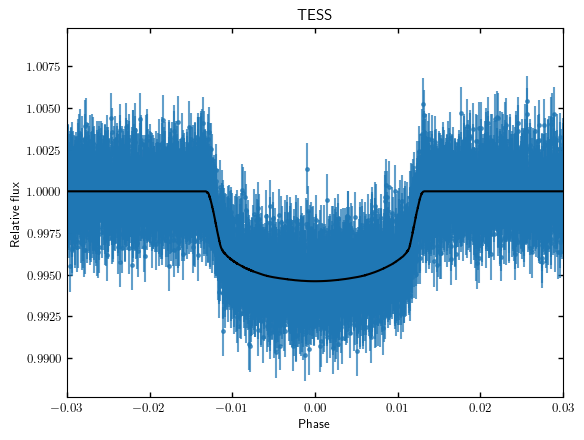

In [11]:
phase_tess, flux_tess, flux_err_tess, model_tess, m_tess, gp_model_tess = plot_with_gp("TESS","TESS","TESS_det.csv",P,t0)

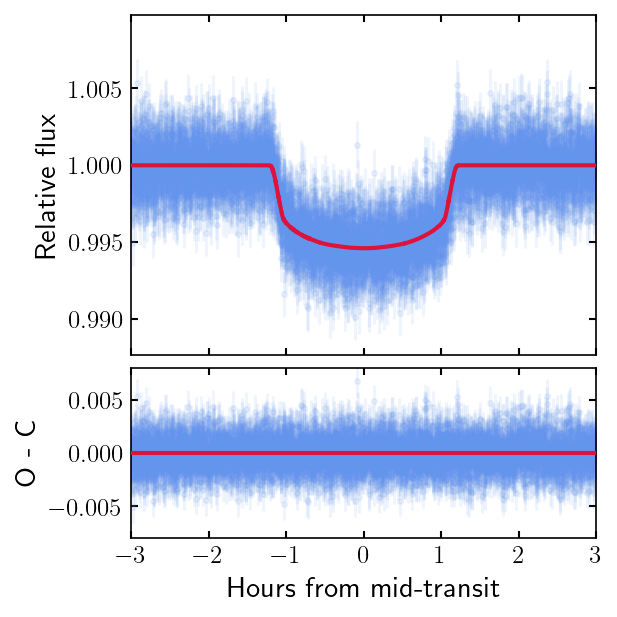

In [30]:
fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :], sharex = ax1)

ax1.errorbar(phase_tess*P*24.,flux_tess-gp_model_tess+m_tess,flux_err_tess,fmt = '.', alpha=0.1,color="cornflowerblue")
idx = np.argsort(phase_tess)
ax1.plot(phase_tess[idx]*P*24.,model_tess[idx]+m_tess, color='crimson',zorder=10,lw=2)

#ax1.set_ylim()
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Relative flux',fontsize=14)

res = flux_tess-gp_model_tess-model_tess

ax2.errorbar(phase_tess*P*24.,res,flux_err_tess,fmt = '.', alpha=0.1,color="cornflowerblue")
ax2.axhline(0.0,lw=2,color="crimson",zorder=30)

ax2.set_xlim(-3,3)
ax2.set_ylim(-0.008,0.008)
#ax2.set_xticks([-2,-1,0,1,2,3])
ax2.set_xlabel(r'Hours from mid-transit',fontsize=14)
ax2.set_ylabel('O - C', fontsize = 14)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

fig.set_facecolor('w')
#plt.tight_layout()
#fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.07),ncol=6, fancybox=True, fontsize=9)
plt.savefig("WASP-156_PHOT.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

# Radial Velocities

In [40]:
def plot_rv(inst):

    global results
    global dataset
    
    fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)
    
    min_time, max_time = np.min(dataset.times_rv[inst])-10,\
                         np.max(dataset.times_rv[inst])+10
    
    model_times = np.linspace(min_time,max_time,100000)
    
    keplerian = results.rv.evaluate(inst, t = model_times) - np.median(results.posteriors['posterior_samples']['mu_'+inst])
    
    color = 'cornflowerblue'
    
    # Evaluate the median jitter for the instrument:
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+inst])
    # Evaluate the median systemic-velocity:
    mu = np.median(results.posteriors['posterior_samples']['mu_'+inst])

    # Plot original errorbars + jitter (added in quadrature):
    plt.errorbar(dataset.times_rv[inst]-2457000,dataset.data_rv[inst]-mu,\
                 yerr = np.sqrt(dataset.errors_rv[inst]**2+jitter**2),fmt='o',\
                 mec=color, ecolor=color, mfc = 'white', label=inst,\
                 alpha = 0.5, zorder=5)
    
    # Plot Keplerian model:
    plt.plot(model_times-2457000, keplerian,color='black',zorder=1)
    plt.ylabel('RV (m/s)', fontsize = 11)
    plt.xlabel('Time (BJD - 2457000)', fontsize = 11)
    plt.show()

    keplerian = results.rv.evaluate(inst, t = dataset.times_rv[inst]) - np.median(results.posteriors['posterior_samples']['mu_'+inst])

    return dataset.times_rv[inst], dataset.data_rv[inst], np.sqrt(dataset.errors_rv[inst]**2+jitter**2), mu, keplerian

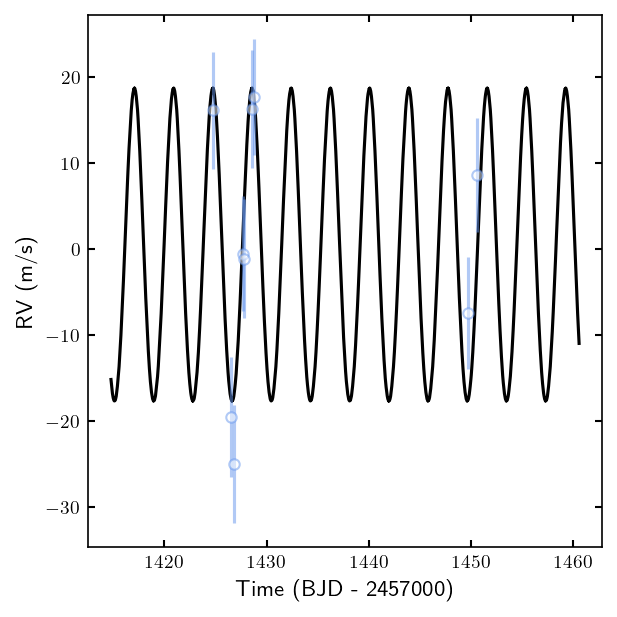

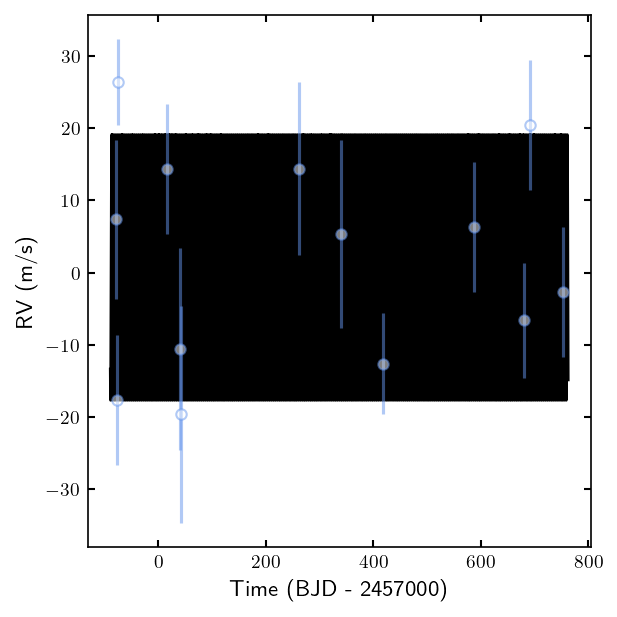

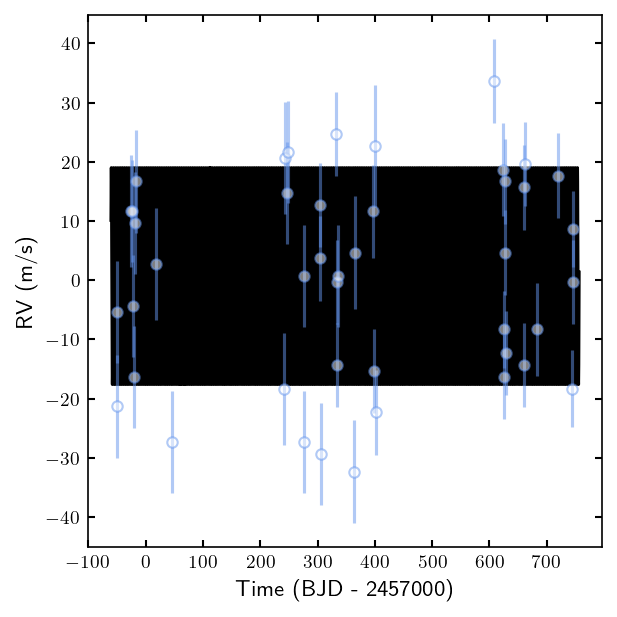

In [41]:
times_harps, rv_harps, rv_err_harps, gamma_harps, model_harps =  plot_rv("HARPS")
times_coralie, rv_coralie, rv_err_coralie, gamma_coralie, model_coralie =  plot_rv("CORALIE")
times_sophie, rv_sophie, rv_err_sophie, gamma_sophie, model_sophie =  plot_rv("SOPHIE")

In [107]:
min_time, max_time = np.min(dataset.times_rv["SOPHIE"]),np.max(dataset.times_rv["SOPHIE"])
model_times = np.linspace(min_time-10,max_time+10,5000)    
keplerian = results.rv.evaluate("SOPHIE", t = model_times, nsamples = 5000, return_samples = True)[0] - np.median(results.posteriors['posterior_samples']['mu_SOPHIE'])

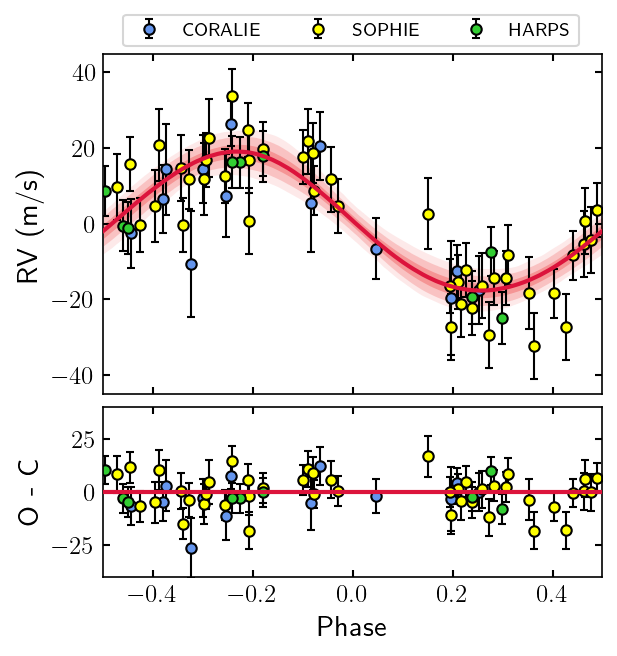

In [117]:
fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :], sharex = ax1)

phase_model = (((model_times-t0 + 0.5*P) % P)/P) - 0.5
phase_harps = (((times_harps-t0 + 0.5*P) % P)/P) - 0.5
phase_coralie = (((times_coralie-t0 + 0.5*P) % P)/P) - 0.5
phase_sophie = (((times_sophie-t0 + 0.5*P) % P)/P) - 0.5

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('RV (m/s)',fontsize=14)

ax1.errorbar(phase_coralie,rv_coralie-gamma_coralie,rv_err_coralie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue",label="CORALIE")
ax1.errorbar(phase_sophie,rv_sophie-gamma_sophie,rv_err_sophie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="yellow",label="SOPHIE")
ax1.errorbar(phase_harps,rv_harps-gamma_harps,rv_err_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="limegreen",label="HARPS")
idx = np.argsort(phase_model)
ax1.plot(phase_model[idx],np.quantile(keplerian,0.5,axis=0)[idx],lw=2,color="crimson",zorder=20)
ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.16,axis=0)[idx],np.quantile(keplerian,0.84,axis=0)[idx],alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.02,axis=0)[idx],np.quantile(keplerian,0.98,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1)
ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.0015,axis=0)[idx],np.quantile(keplerian,0.9985,axis=0)[idx],alpha=0.1,color="#EE2C2C",lw=0,zorder=-1)

res_harps = rv_harps-gamma_harps-model_harps
res_coralie = rv_coralie-gamma_coralie-model_coralie
res_sophie = rv_sophie-gamma_sophie-model_sophie

ax2.errorbar(phase_coralie,res_coralie,rv_err_coralie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax2.errorbar(phase_sophie,res_sophie,rv_err_sophie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="yellow")
ax2.errorbar(phase_harps,res_harps,rv_err_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="limegreen")
ax2.axhline(0.0,lw=2,color="crimson",zorder=30)

ax2.set_xlim(-0.5,0.5)
ax2.set_ylim(-40,40)
ax2.set_yticks([-25,0,25])
ax2.set_xlabel(r'Phase',fontsize=14)
ax2.set_ylabel('O - C', fontsize = 14)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

fig.set_facecolor('w')
#plt.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.57, 1.07),ncol=6, fancybox=True, fontsize=9)
plt.savefig("WASP-156_RVs_phase.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

# Don't really know what is below

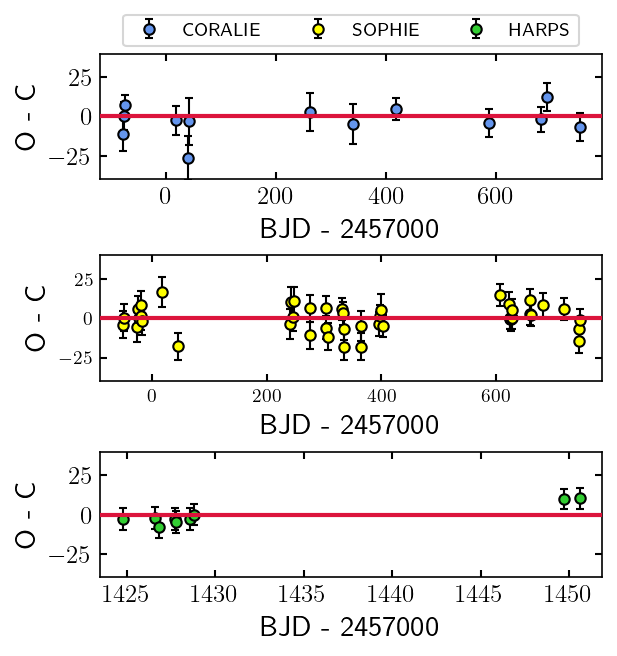

In [118]:
fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[0, :])
ax3 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])

phase_model = (((model_times-t0 + 0.5*P) % P)/P) - 0.5
phase_harps = (((times_harps-t0 + 0.5*P) % P)/P) - 0.5
phase_coralie = (((times_coralie-t0 + 0.5*P) % P)/P) - 0.5
phase_sophie = (((times_sophie-t0 + 0.5*P) % P)/P) - 0.5

#plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('RV (m/s)',fontsize=14)

#ax1.errorbar(phase_coralie,rv_coralie-gamma_coralie,rv_err_coralie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue",label="CORALIE")
#ax1.errorbar(phase_sophie,rv_sophie-gamma_sophie,rv_err_sophie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="yellow",label="SOPHIE")
#ax1.errorbar(phase_harps,rv_harps-gamma_harps,rv_err_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="limegreen",label="HARPS")
#idx = np.argsort(phase_model)
#ax1.plot(phase_model[idx],np.quantile(keplerian,0.5,axis=0)[idx],lw=2,color="crimson",zorder=20)
#ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.16,axis=0)[idx],np.quantile(keplerian,0.84,axis=0)[idx],alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
#ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.02,axis=0)[idx],np.quantile(keplerian,0.98,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1)
#ax1.fill_between(phase_model[idx],np.quantile(keplerian,0.0015,axis=0)[idx],np.quantile(keplerian,0.9985,axis=0)[idx],alpha=0.1,color="#EE2C2C",lw=0,zorder=-1)

res_harps = rv_harps-gamma_harps-model_harps
res_coralie = rv_coralie-gamma_coralie-model_coralie
res_sophie = rv_sophie-gamma_sophie-model_sophie

ax1.errorbar(times_coralie-2457000,res_coralie,rv_err_coralie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue", label = "CORALIE")
ax3.errorbar(times_sophie-2457000,res_sophie,rv_err_sophie,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="yellow", label = "SOPHIE")
ax2.errorbar(times_harps-2457000,res_harps,rv_err_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="limegreen", label = "HARPS")
ax1.axhline(0.0,lw=2,color="crimson",zorder=30)
ax2.axhline(0.0,lw=2,color="crimson",zorder=30)
ax3.axhline(0.0,lw=2,color="crimson",zorder=30)

#ax2.set_xlim(-0.5,0.5)
ax1.set_ylim(-40,40)
ax1.set_yticks([-25,0,25])
ax1.set_xlabel(r'BJD - 2457000',fontsize=14)
ax1.set_ylabel('O - C', fontsize = 14)

#ax2.set_xlim(-0.5,0.5)
ax3.set_ylim(-40,40)
ax3.set_yticks([-25,0,25])
ax3.set_xlabel(r'BJD - 2457000',fontsize=14)
ax3.set_ylabel('O - C', fontsize = 14)

#ax2.set_xlim(-0.5,0.5)
ax2.set_ylim(-40,40)
ax2.set_yticks([-25,0,25])
ax2.set_xlabel(r'BJD - 2457000',fontsize=14)
ax2.set_ylabel('O - C', fontsize = 14)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

fig.set_facecolor('w')
#plt.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.57, 1.07),ncol=6, fancybox=True, fontsize=9)
plt.savefig("WASP-156_RVs_time.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [121]:
def find_period(x, y, dy, per_min=0.1, per_max=100, vlines=None, plot=True, custom_labels=None):
    # Calculate the Generalized Lomb-Scargle periodogram
    ls = LombScargle(x, y, dy)
    frequency = 1. / np.logspace(np.log10(per_min), np.log10(per_max), 100000)
    power = ls.power(frequency)

    # Plot the periodogram
    if plot:
        plt.plot(1. / frequency, power)
        probabilities = [0.1, 0.05, 0.01]
        FAP = ls.false_alarm_level(probabilities)
        for i in FAP:
            plt.axhline(i, linestyle="--", color="k")
        if vlines is not None:
            for val in vlines:
                plt.axvline(val, linestyle="-.", color="r")
        if custom_labels:
            plt.xlabel(custom_labels.get('xlabel', 'Period (d)'))
            plt.ylabel(custom_labels.get('ylabel', 'Power'))
        else:
            plt.xlabel("Period (d)")
            plt.ylabel("Power")
        plt.xscale("log")
        plt.show()
    
    # Find the best period
    best_frequency = frequency[np.argmax(power)]
    best_period = 1. / best_frequency
    
    # Print results
    print("Best Period =", best_period, "days")
    print("False Alarm Probability =", ls.false_alarm_probability(power.max()))
    
    # Return results
    results = {
        'best_period': best_period,
        'power': power,
        'frequency': frequency,
        'false_alarm_probabilities': ls.false_alarm_level(probabilities)
    }
    return best_period, results

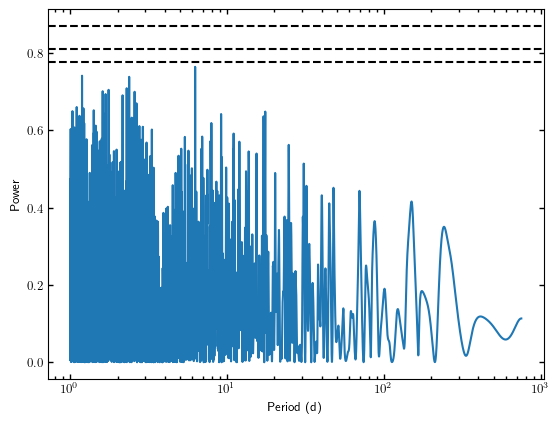

Best Period = 6.2446579657275185 days
False Alarm Probability = 0.12626781753342245


In [122]:
per, res = find_period(times_coralie,res_coralie,rv_err_coralie,per_min=1.,per_max=750.)

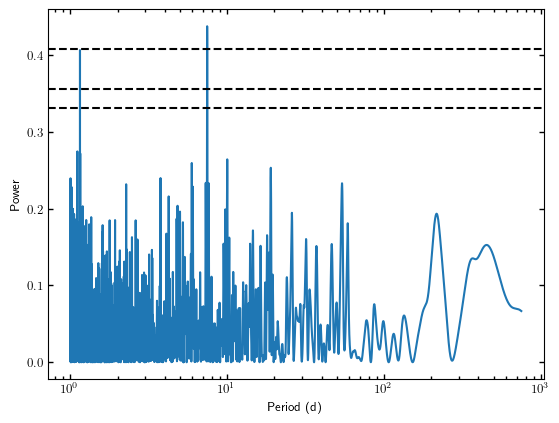

Best Period = 7.449052824112155 days
False Alarm Probability = 0.0037794791135595763


In [123]:
per, res = find_period(times_sophie,res_sophie,rv_err_sophie,per_min=1.,per_max=750.)

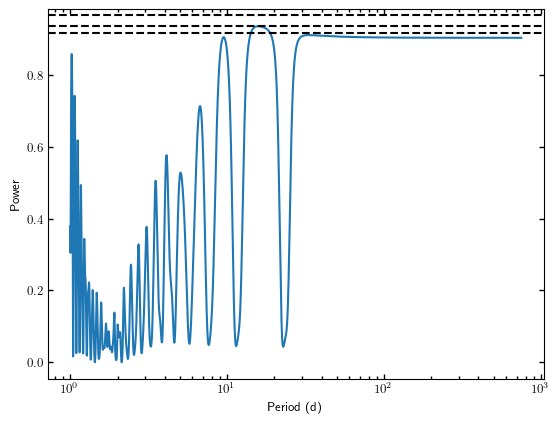

Best Period = 15.769575463981413 days
False Alarm Probability = 0.054023410162334945


In [124]:
per, res = find_period(times_harps,res_harps,rv_err_harps,per_min=1.,per_max=750.)